# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../common_settings.py

# Load data

In [2]:
ad = sc.read('../20200403_post_annot3_cleanup/fetal_skin.lymphoid_T_NK.doublet_removed_processed.20200403.h5ad')

Only considering the two last: ['.20200403', '.h5ad'].
Only considering the two last: ['.20200403', '.h5ad'].


In [3]:
ad

AnnData object with n_obs × n_vars = 17943 × 20535
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_r0_4_split', 'rachel_annot2', 'leiden_hm_split1', 'rachel_annot3'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_bk', 'neighbors_hm', 'pca'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm', 'X_umap_bk'
    varm: 'PCs'
    obsp: 'distances',

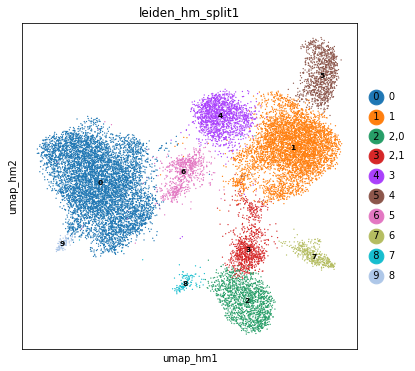

In [5]:
sk.plot_embedding(ad, basis='umap_hm', groupby='leiden_hm_split1', figsize=(6, 6));

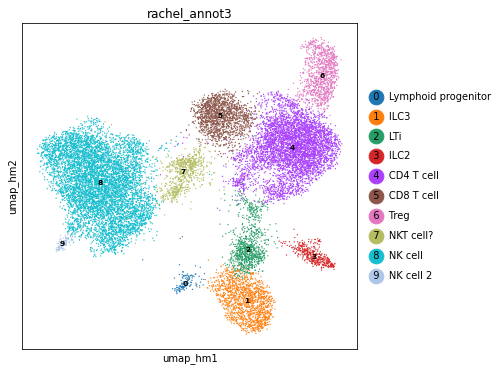

In [97]:
sk.plot_embedding(ad, basis='umap_hm', groupby='rachel_annot3', figsize=(6, 6));

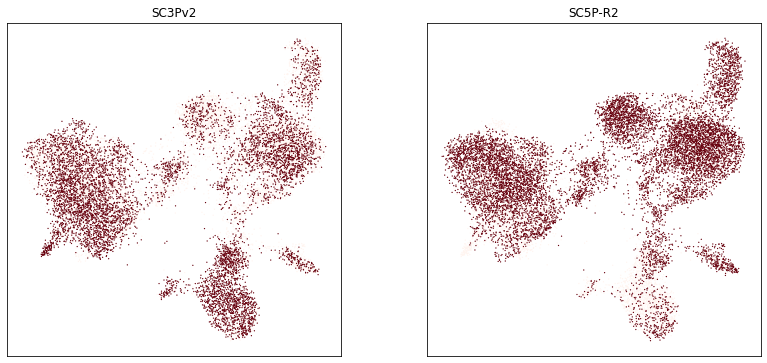

In [99]:
sk.highlight(ad, basis='umap_hm', groupby='chemistry', figsize=(6, 6));

# Recluster

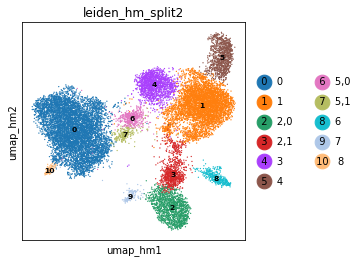

In [14]:
sk.leiden(ad, resolution=0.3, use_graph='neighbors_hm', restrict_to=('leiden_hm_split1', ['5']), key_added='hm_split2', legacy=True)
sk.plot_embedding(ad, basis='umap_hm', groupby='leiden_hm_split2', figsize=(4, 4));

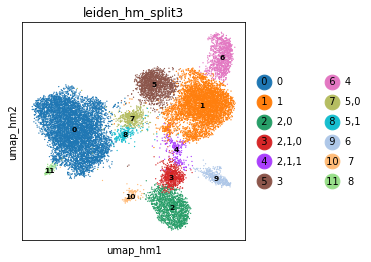

In [37]:
sk.leiden(ad, resolution=0.2, use_graph='neighbors_hm', restrict_to=('leiden_hm_split2', ['2,1']), key_added='hm_split3', legacy=True)
sk.plot_embedding(ad, basis='umap_hm', groupby='leiden_hm_split3', figsize=(4, 4));

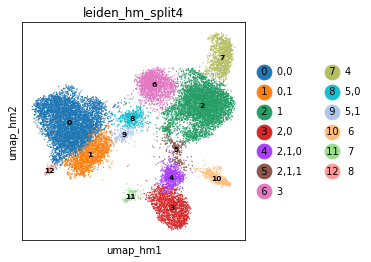

In [41]:
sk.leiden(ad, resolution=0.3, use_graph='neighbors_hm', restrict_to=('leiden_hm_split3', ['0']), key_added='hm_split4', legacy=True)
sk.plot_embedding(ad, basis='umap_hm', groupby='leiden_hm_split4', figsize=(4, 4));

In [105]:
ad.obs.rachel_annot3.cat.categories

Index(['Lymphoid progenitor', 'ILC3', 'LTi', 'ILC2', 'CD4 T cell',
       'CD8 T cell', 'Treg', 'NKT cell?', 'NK cell', 'NK cell 2'],
      dtype='object')

In [106]:
ad.obs['nh3_annot1'] = sk.regroup(ad, groupby='leiden_hm_split4', regroups={
    'CD4 T cell': '1',
    'CD8 T cell': '3',
    'Treg': '4',
    'NK cell': ['0,0', '0,1'],
    'NK cell 2': '8',
    'NKT cell?': '5,0',
    'gdT cell?': '5,1',
    'Unknown T cell': '2,1,1',
    'LTi cell': '2,1,0',
    'ILC2': '6',
    'ILC3': '2,0',
    'Lymphoid progenitor': '7',
})

In [107]:
mkst = sk.calc_marker_stats(ad, groupby='nh3_annot1')

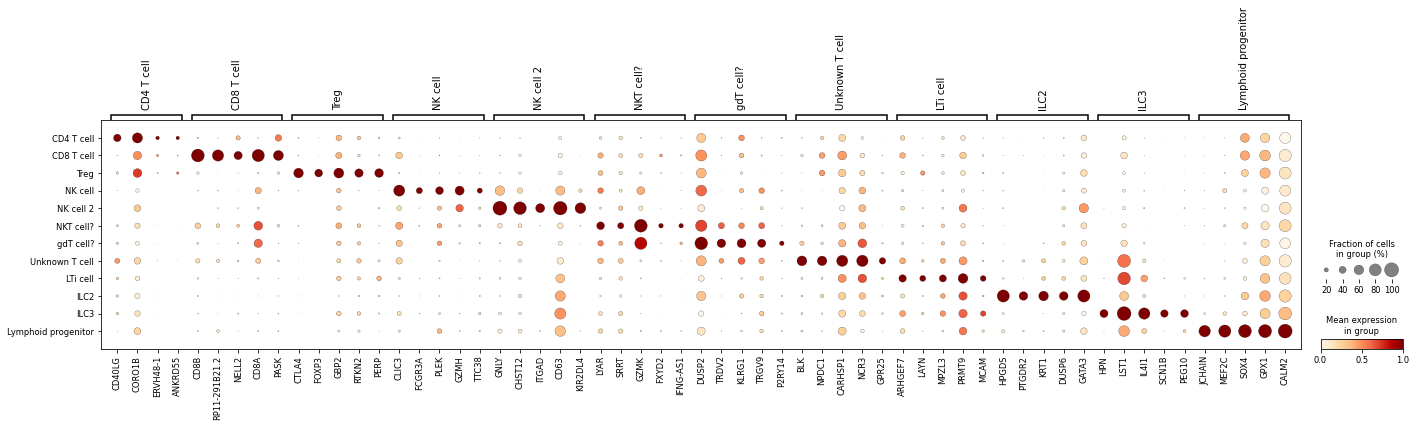

In [128]:
mks = sk.filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.3, how='or', single=False)
sk.plot_markers(ad, groupby='nh3_annot1', mks=mks, standard_scale='var', cmap='OrRd')

In [129]:
deg = sk.diffexp(ad, groupby='nh3_annot1', method='t-test_overestim_var', filter_params=[0.4, 0.1, 1.5])

In [139]:
deg = sk.extract_de_table(ad.uns['rank_genes_groups'])

In [150]:
deg.groupby('cluster').head(100).to_csv('fetal_skin.lymphoid_T_NK.20210423.DE_top100.tsv', sep='\t', index=False)

In [138]:
mksp.cluster.value_counts()

NK cell 2              97
Lymphoid progenitor    83
CD8 T cell             82
ILC3                   80
Unknown T cell         69
ILC2                   68
Treg                   52
NK cell                22
gdT cell?              18
LTi cell               13
NKT cell?              10
CD4 T cell              4
Name: cluster, dtype: int64

categories: CD4 T cell, CD8 T cell, Treg, etc.
var_group_labels: CD4 T cell, CD8 T cell, Treg, etc.


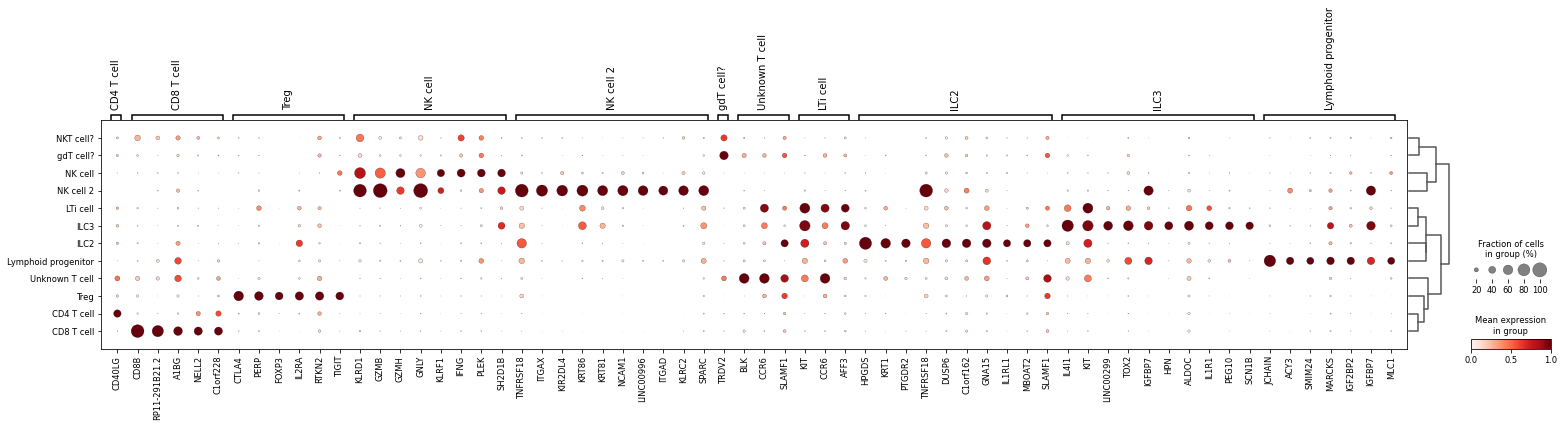

In [132]:
sc.pl.rank_genes_groups_dotplot(ad, key='rank_genes_groups_filtered', standard_scale='var')

In [125]:
mksp = sk.test_markers(ad, mks, groupby='nh3_annot1', method='t-test_overestim_var').where(lambda x: (x.pvals_adj < 0.05) & ~np.isnan(x.pvals_adj)).dropna()[[
    'cluster', 'genes', 'top_frac', 'frac_diff', 'top_mean', 'mean_diff', 'logfoldchanges', 'pvals', 'pvals_adj'
]]

In [126]:
mksp.to_csv('fetal_skin.lymphoid_T_NK.20210423.markers.tsv', sep='\t', index=False)

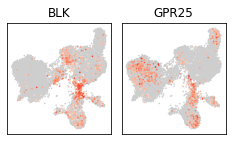

In [101]:
sk.plot_genes(
    ad,
    basis='umap_hm',
    genes=['BLK', 'GPR25'],
    size=10,
    vmin=0, vmax=5
)

In [149]:
sk.clear_colors(ad)
ad.write('fetal_skin.lymphoid_T_NK.doublet_removed_processed.20210423.h5ad', compression='lzf')

## Zoom into NKT/gdT

In [54]:
ad.obs.rachel_annot3.cat.categories

Index(['Lymphoid progenitor', 'ILC3', 'LTi', 'ILC2', 'CD4 T cell',
       'CD8 T cell', 'Treg', 'NKT cell?', 'NK cell', 'NK cell 2'],
      dtype='object')

In [55]:
nkgd_ad = sk.restore_adata(ad[ad.obs.rachel_annot3=='NKT cell?'].copy(), restore_type='norm')

In [56]:
nkgd_ad

AnnData object with n_obs × n_vars = 704 × 20535
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_r0_4_split', 'rachel_annot2', 'leiden_hm_split1', 'rachel_annot3', 'leiden_hm_split2', 'leiden_hm_split3', 'leiden_hm_split4'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells'

In [57]:
nkgd_ad.obs.sanger_id.value_counts()

FCAImmP7803034     155
FCAImmP7803035     130
FCAImmP7803025      88
FCAImmP7528296      65
FCAImmP7528290      54
FCAImmP7803024      50
FCAImmP7555858      28
FCAImmP7316886      23
FCAImmP7579212      22
FCAImmP7964506      20
FCAImmP7316887      19
FCAImmP7964507      15
FCAImmP7352189      12
FCAImmP7462240       7
FCAImmP7579224       7
FCAImmP7316896       5
FCAImmP7964502       3
4834STDY7002879      1
Name: sanger_id, dtype: int64

In [75]:
nkgd_ad1 = nkgd_ad[nkgd_ad.obs.sanger_id.isin(sk.get_good_sized_batch(nkgd_ad.obs.sanger_id, min_size=5))].copy()

In [76]:
nkgd_ad2 = sk.simple_default_pipeline(
    nkgd_ad1, post_norm_only=True, batch='sanger_id', batch_method='harmony',
    do_clustering=True,
    clustering_resolution=[0.2, 0.3, 0.4],
    hvg_kw={'by_batch': ('sanger_id', 1), 'n_hvg': 200},
    pca_kw={'remove_genes': ('mito', 'ribo')}
)

2021-04-29 08:22:28,784 - harmonypy - INFO - Iteration 1 of 20
2021-04-29 08:22:28,893 - harmonypy - INFO - Iteration 2 of 20
2021-04-29 08:22:28,959 - harmonypy - INFO - Iteration 3 of 20
2021-04-29 08:22:29,019 - harmonypy - INFO - Iteration 4 of 20
2021-04-29 08:22:29,065 - harmonypy - INFO - Iteration 5 of 20
2021-04-29 08:22:29,109 - harmonypy - INFO - Iteration 6 of 20
2021-04-29 08:22:29,155 - harmonypy - INFO - Iteration 7 of 20
2021-04-29 08:22:29,190 - harmonypy - INFO - Iteration 8 of 20
2021-04-29 08:22:29,240 - harmonypy - INFO - Iteration 9 of 20
2021-04-29 08:22:29,289 - harmonypy - INFO - Iteration 10 of 20
2021-04-29 08:22:29,334 - harmonypy - INFO - Iteration 11 of 20
2021-04-29 08:22:29,377 - harmonypy - INFO - Converged after 11 iterations


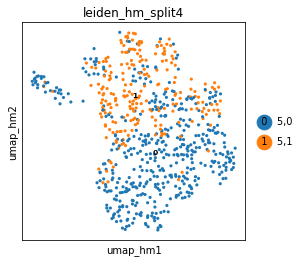

In [80]:
sk.plot_embedding(nkgd_ad2, basis='umap_hm', groupby='leiden_hm_split4', size=40);

In [90]:
nkgd_ad2.obs['leiden_hm_r0_25'] = sk.regroup(nkgd_ad2, groupby='leiden_hm_r0_3', regroups={
    '0': ['0', '1'],
    '1': ['2'],
    '2': ['3']
})

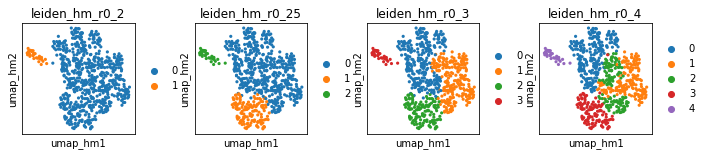

In [91]:
sk.pl.embedding(nkgd_ad2, basis='umap_hm', color=['leiden_hm_r0_2', 'leiden_hm_r0_25', 'leiden_hm_r0_3', 'leiden_hm_r0_4'], size=40);

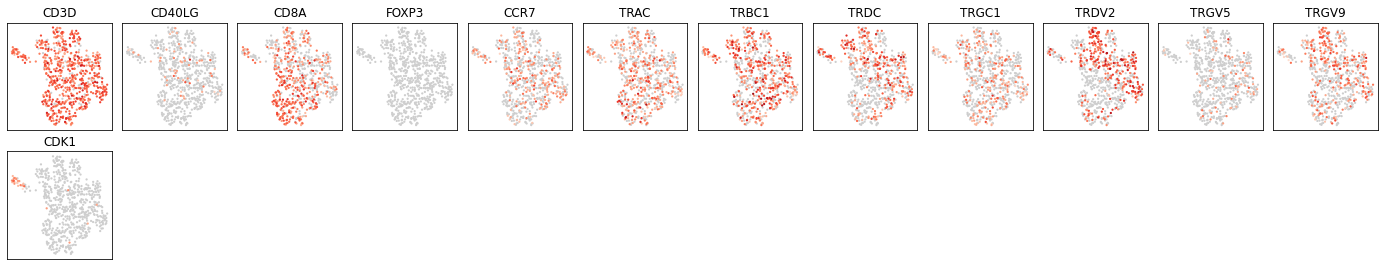

In [84]:
sk.plot_genes(
    nkgd_ad2,
    basis='umap_hm',
    genes=['CD3D', 'CD40LG', 'CD8A', 'FOXP3', 'CCR7', 'TRAC', 'TRBC1', 'TRDC', 'TRGC1', 'TRDV2', 'TRGV5', 'TRGV9', 'CDK1'],
    size=20,
    vmin=0, vmax=5
)

In [92]:
nkgd_mkst = sk.calc_marker_stats(nkgd_ad2, groupby='leiden_hm_r0_25')

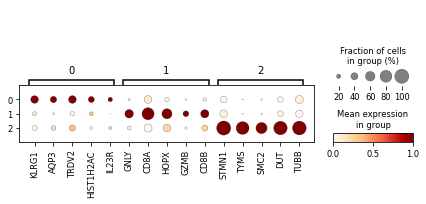

In [94]:
nkgd_mks = sk.filter_marker_stats(nkgd_mkst[2], max_next_frac=0.5, how='and')
sk.plot_markers(nkgd_ad2, groupby='leiden_hm_r0_25', mks=nkgd_mks, standard_scale='var', cmap='OrRd')